# Part-5 section-2

### Plot a graph of training and validation error with respect to depth of your decision tree. Also plot the training and validation error with respect to number of nodes in the decision tree.


In [1]:
import numpy as np
import pandas as pd
import pprint
import sys

eps = np.finfo(float).eps
true_positive = 0
true_negative = 0
false_positive = 0
false_negative = 0
MAX_HEIGHT = 0
from numpy import log2 as log
targetattr = "left"
dataSet = pd.read_csv("./../input_data/train.csv")
numerical = ['satisfaction_level' , 'last_evaluation' , 'number_project' , 'average_montly_hours' , 'time_spend_company']
catagorical = ['Work_accident' , 'promotion_last_5years' , 'sales' , 'salary']
trainingSet , validationSet = np.split(dataSet,[int(0.8*len(dataSet))])


#### maxInfoGainNodeSplit function decides which attribute is selected as node and give the binary splite point in case of numerical attribute

In [2]:
def maxInfoGainNodeSplit(df):
    attributes = list(df)
    maxGain = 0.0
    gain = 0.0
    split = 0
    temp = 0.0
    entropybefore = entropy(df)
    for attr in attributes:
        if attr != targetattr:
            if attr in catagorical:
                gain = entropybefore - I(df,attr)
                if maxGain < gain:
                    maxGain = gain
                    node = attr
                    split = 0
            else:
                temp, ImpurityNum = InumMin(df,attr)
                gain = entropybefore - ImpurityNum
                if maxGain < gain:
                    maxGain = gain
                    node = attr
                    split = temp
    if maxGain == 0.0:
        return None , split
    else:
        return node , split


#### entropy function for entropy before spliting

In [3]:
def entropy(df):
    entropy = 0
    uniqueSet = df[targetattr].unique()
    for elem in uniqueSet:
        fraction = df[targetattr].value_counts()[elem]/float(len(df)+ eps)
        entropy += -fraction*np.log2(fraction + eps)
    return entropy

#### entropy_attr function for entropy after spliting


In [4]:
def entropy_attr(num_of_ones , total):
    fraction1 = num_of_ones/(total + eps)
    fraction2 = (total - num_of_ones)/(total + eps)
    entropy = -fraction1*np.log2(fraction1 + eps) - fraction2*np.log2(fraction2 + eps)
    return entropy

#### InumMin function to calculate minimun impurity for weighted entropy in numerical attribute

In [5]:
def InumMin(df , attribute):
    target_variables = df[targetattr].unique()  #This gives all 'Yes' and 'No'
#     print("TARGET VARS : ",target_variables[0])
    variables = df[attribute].unique()    #This gives different features in that attribute (like 'Hot','Cold' in Temperature)
    
    variables.sort()
    
    split = 0
    minInum = sys.float_info.max
    total_ones = df[targetattr].value_counts()[target_variables[0]]
    arr = df[[attribute, targetattr]].values
    arr = arr[np.argsort(arr[:, 0])]

    nRows = arr.shape[0]

    num_of_ones = 0
    i = 0
    for variable in variables:
        impurity = 0.0
        while (i < nRows and arr[i][0] == variable) :
            if arr[i][1] == target_variables[0]:
                num_of_ones += 1
            i += 1
        num_left = i
        fraction_left = num_left/(nRows + eps)
        if num_left == 0:
            impurity += 0.0
        else:
            impurity += fraction_left*entropy_attr(num_of_ones , num_left) 
            
        num_right = nRows - num_left
        fraction_right = num_right/(nRows + eps)
        if num_right == 0:
            impurity += 0.0
        else:
            impurity += fraction_right*entropy_attr(total_ones - num_of_ones , num_right) 
        
        if minInum > impurity:
            minInum = impurity
            split = variable
        
    return split , minInum

#### Impurity function to calculate impurity for weighted entropy

In [6]:
def I(df , attribute):
    target_variables = df[targetattr].unique()  #This gives all 'Yes' and 'No'
    variables = df[attribute].unique()    #This gives different features in that attribute (like 'Hot','Cold' in Temperature)
    den = len(df[attribute])
    impurity = 0
    for variable in variables:
        num = len(df[attribute][df[attribute] == variable])
        fraction = num/(den + eps)
        if num == 0:
            impurity += 0.0
        else:
            impurity += fraction*entropy(df[df[attribute] == variable]) 
    return impurity

#### get_subtableCat to filter data frame that has catagorical attribute

In [7]:
def get_subtableCat(df, node,value):
    return df[df[node] == value].reset_index(drop=True)


#### get_subtableCat to filter data frame that has numerical attribute


In [8]:
def get_subtableNum(df, node, value):
    return df[df[node] <= value].reset_index(drop=True) , df[df[node] > value].reset_index(drop=True)

#### Tree Builder Function


In [9]:
def treeBuilder(df, depth ,tree=None):     
    #Here we build our decision tree   
    #Get attribute with maximum information gain
    node, split = maxInfoGainNodeSplit(df)
    clValue,counts = np.unique(df[targetattr],return_counts=True)  
    if node is None:
        return clValue[np.argmax(counts)]

#     print (node)
    
    #Create an empty dictionary to create tree    
    if tree is None:                    
        tree={}
        tree[node] = {}
        tree['DEPTH'] = depth
        tree['CUR_VALUE'] = clValue[np.argmax(counts)]
        tree['DF_SIZE'] = len(df)
    if node in catagorical:
        #Get distinct value of that attribute e.g Salary is node and Low,Med and High are values
        attValue = np.unique(df[node])


       #We make loop to construct a tree by calling this function recursively. 
        #In this we check if the subset is pure and stops if it is pure. 

        for value in attValue:
            subtable = get_subtableCat(df,node,value)
            clValue,counts = np.unique(subtable[targetattr],return_counts=True)                        

            if len(counts)==1:#Checking purity of subset
                tree[node][value] = clValue[0]
            else:        
                tree[node][value] = treeBuilder(subtable , depth + 1) #Calling the function recursively 
                
    elif node in numerical:
        left_subtable , right_subtable = get_subtableNum(df,node,split)
        
        clValue,counts = np.unique(left_subtable[targetattr],return_counts=True)                      
        
        if len(counts)==1:#Checking purity of subset
            tree[node][split] = clValue[0]
        else:        
            tree[node][split] = treeBuilder(left_subtable , depth + 1) #Calling the function recursively 
            
        clValue,counts = np.unique(right_subtable[targetattr],return_counts=True)                        
        
        if len(counts)==1:#Checking purity of subset
            tree[node][split + 0.00002] = clValue[0]
        else:        
            tree[node][split + 0.00002] = treeBuilder(right_subtable , depth + 1) #Calling the function recursively 
            
    return tree


#### Run the code to build the tree

In [10]:
tree = treeBuilder(trainingSet,0)
pprint.pprint(tree)



{'CUR_VALUE': 0,
 'DEPTH': 0,
 'DF_SIZE': 8990,
 'satisfaction_level': {0.46: {'CUR_VALUE': 1,
                               'DEPTH': 1,
                               'DF_SIZE': 2504,
                               'satisfaction_level': {0.11: 1,
                                                      0.11002: {'CUR_VALUE': 0,
                                                                'DEPTH': 2,
                                                                'DF_SIZE': 1956,
                                                                'number_project': {2: {'CUR_VALUE': 1,
                                                                                       'DEPTH': 3,
                                                                                       'DF_SIZE': 1014,
                                                                                       'last_evaluation': {0.57: {'CUR_VALUE': 1,
                                                                              

                                                                                                                                                                                        'number_project': {4: 0,
                                                                                                                                                                                                           4.00002: {'CUR_VALUE': 0,
                                                                                                                                                                                                                     'DEPTH': 7,
                                                                                                                                                                                                                     'DF_SIZE': 12,
                                                                                                             

#### predict function predicts the value of class attribute for a given row of input and tree 

In [11]:
def predict(tree , row, df_size = None):
    #This function is used to predict for any input variable 
    
    #Recursively we go through the tree that we built earlier
    if tree['DF_SIZE'] <= df_size:
        return tree['CUR_VALUE']
    prediction = 0
    for nodes in tree.keys():  
        if nodes == 'DEPTH' or nodes == 'CUR_VALUE' or nodes == 'DF_SIZE':
            continue
        value = row[nodes]
        if nodes in catagorical:
            if value in list((tree[nodes]).keys()):
                tree = tree[nodes][value]
            else:
                zeros = 0
                ones = 0
                for i in tree[nodes].keys():
                    if tree[nodes][i] == 0:
                        zeros += 1
                    elif tree[nodes][i] == 1:
                        ones += 1
                if zeros > ones:
                    return 0
                else:
                    return 1
        else:
            binaryValue = list(tree[nodes].keys())
            if value <= binaryValue[0]:
                tree = tree[nodes][binaryValue[0]]
            else:
                tree = tree[nodes][binaryValue[1]]
        if type(tree) is dict:
            prediction = predict(tree , row, df_size)
        else:
            prediction = tree
            break;   
            
    return prediction

#### validate function validates the given Data Frame

In [12]:
def validate(tree, df):
    ACC = []
    for i in range(0,9200,100):
        correct = 0
        wrong = 0
        for index, row in df.iterrows():
            if predict(tree, row, i) == row[targetattr]:
                correct += 1
            else:
                wrong += 1
        ACC.append(100.0*correct/(correct + wrong + eps))
    print(ACC)
    return ACC


#### Plotting the Accuracy-vs-Nodes graph


[97.77580071174377, 97.8202846975089, 97.90925266903915, 97.90925266903915, 97.90925266903915, 97.90925266903915, 97.15302491103203, 97.15302491103203, 95.41814946619218, 95.41814946619218, 94.48398576512456, 93.81672597864768, 90.70284697508897, 90.70284697508897, 90.70284697508897, 90.70284697508897, 90.70284697508897, 90.70284697508897, 90.70284697508897, 90.70284697508897, 81.45017793594306, 81.45017793594306, 81.45017793594306, 81.45017793594306, 81.45017793594306, 81.45017793594306, 81.76156583629893, 81.76156583629893, 81.76156583629893, 81.76156583629893, 81.76156583629893, 81.76156583629893, 81.76156583629893, 81.76156583629893, 81.76156583629893, 81.76156583629893, 81.76156583629893, 81.76156583629893, 81.76156583629893, 81.76156583629893, 81.76156583629893, 81.76156583629893, 81.76156583629893, 81.76156583629893, 81.76156583629893, 81.76156583629893, 81.76156583629893, 81.76156583629893, 81.76156583629893, 81.76156583629893, 81.76156583629893, 81.76156583629893, 81.761565836

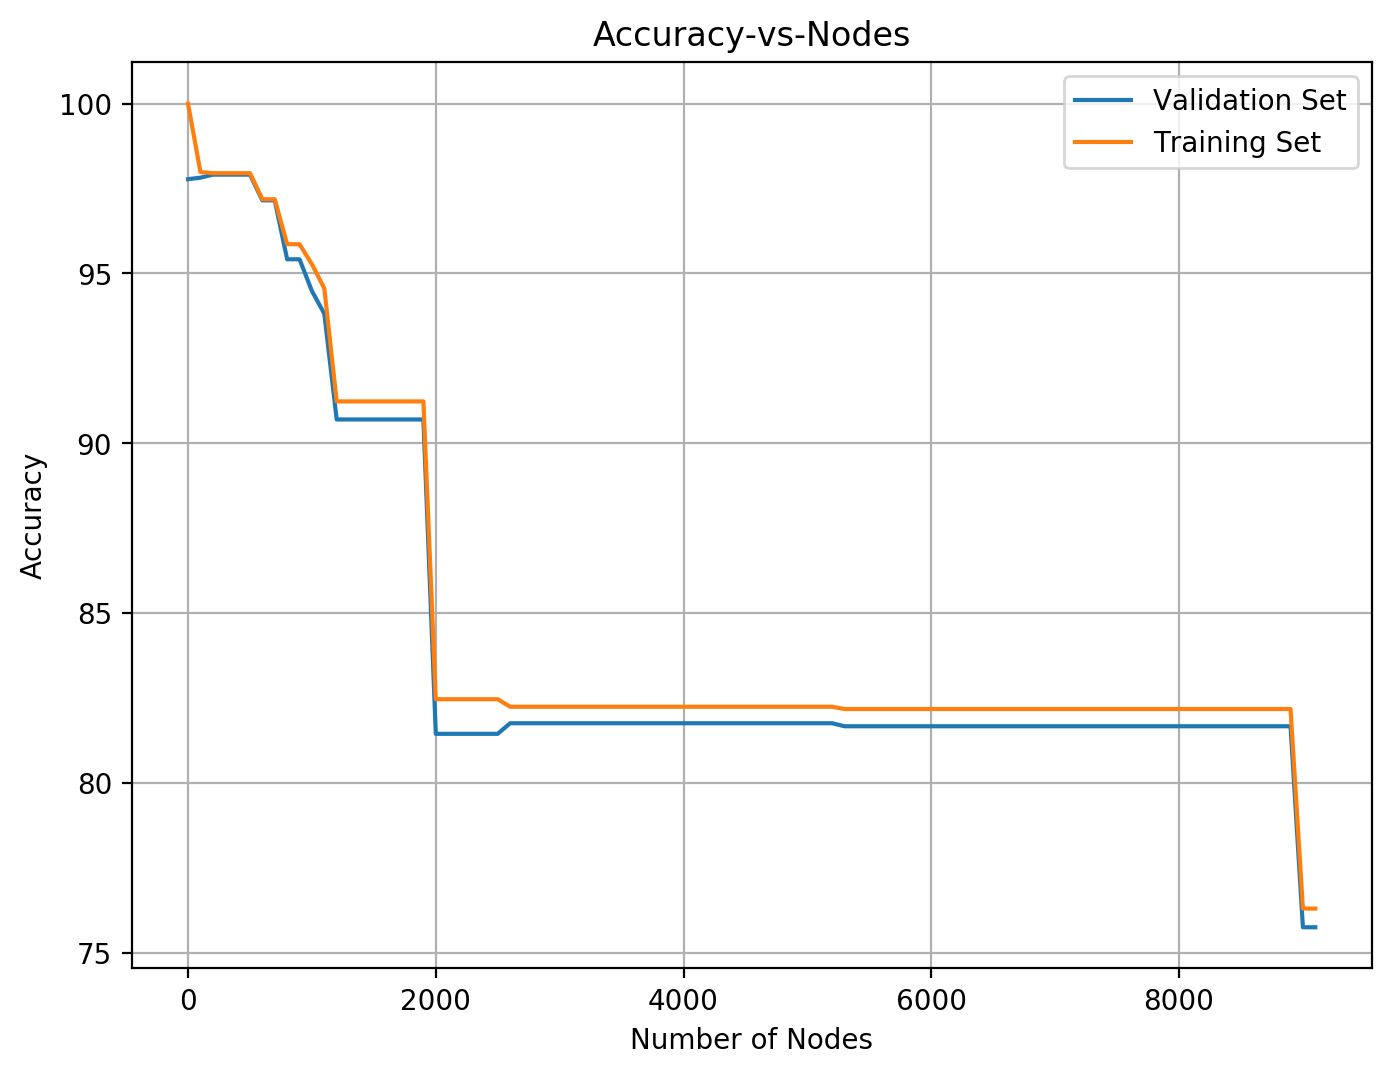

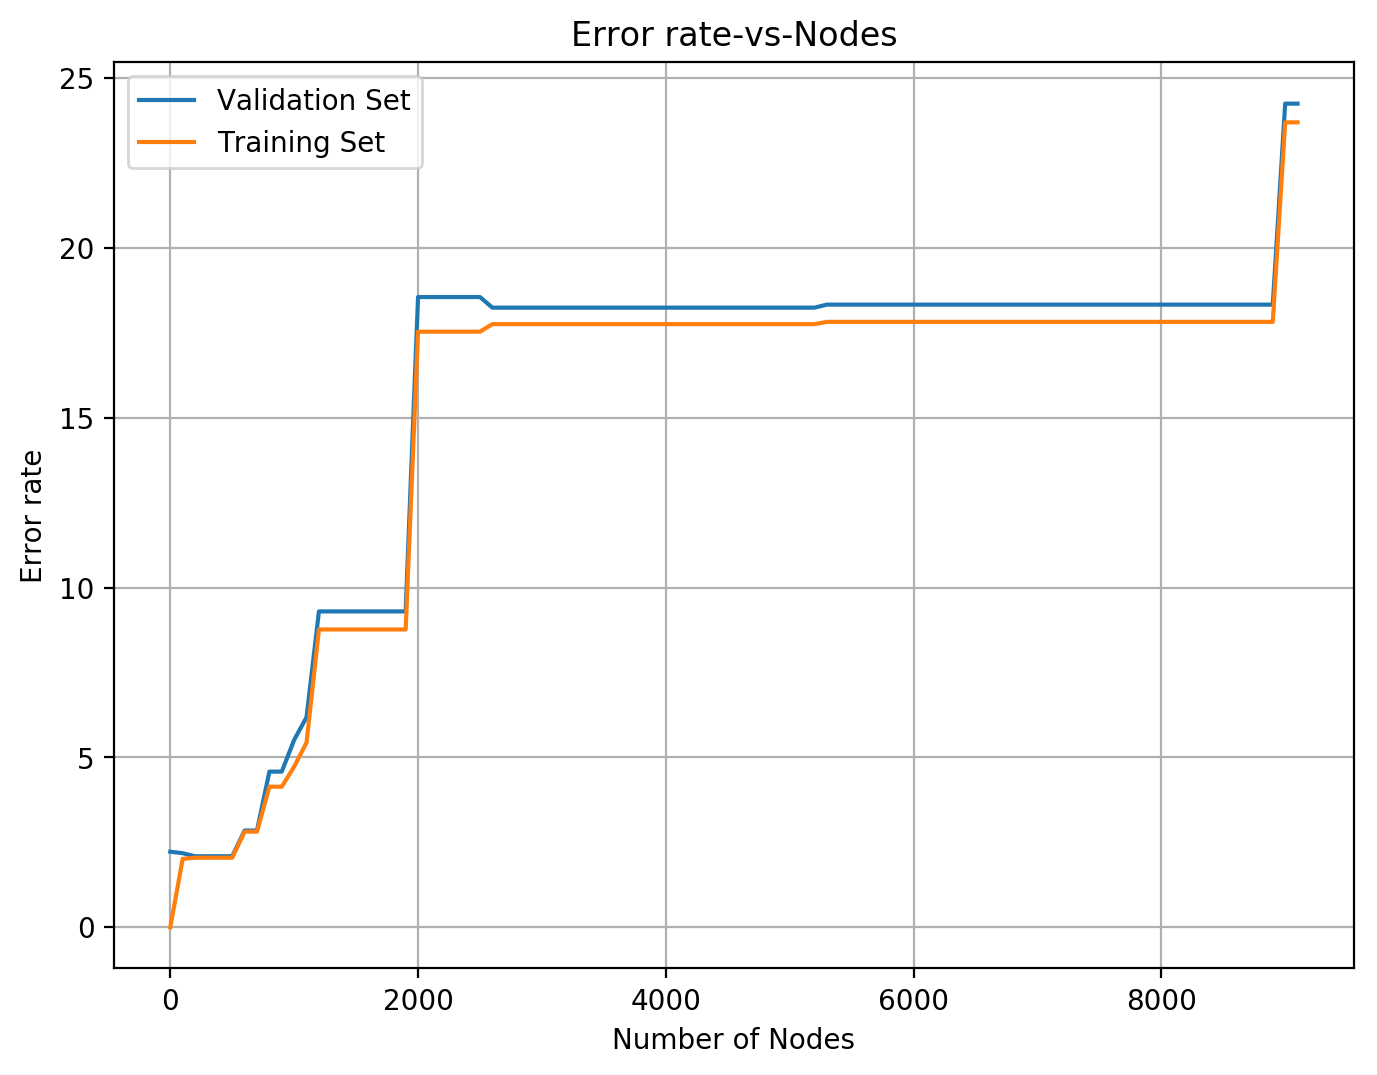

In [14]:
import matplotlib.pyplot as plt
ACC_validSet = validate(tree , validationSet)
ACC_trainSet = validate(tree , trainingSet)
 
NODES = []
for i in  range(0 , len(ACC_validSet)):
    NODES.append(i*100)
#     print("ValidationSet Accuracy at depth: "+ str(i*100) +" is "+ str(ACC_validSet[i]) + "%")
#     print("TrainingSet Accuracy at depth: "+ str(i*100) +" is "+ str(ACC_trainSet[i]) + "%")
    
plt.figure(num=None, figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')
# plotting the points  
plt.plot(NODES, ACC_validSet, label = "Validation Set") 
plt.plot(NODES, ACC_trainSet, label = "Training Set")  
# naming the x axis 
plt.xlabel('Number of Nodes') 
# naming the y axis 
plt.ylabel('Accuracy') 
  
# giving a title to my graph 
plt.title('Accuracy-vs-Nodes') 
plt.grid(True)
plt.legend() 

plt.savefig('./../output_data/Plot/5.2 Accuracy-vs-Nodes.png')

# function to show the plot 
plt.show()


ACC_validSet[:] = [100 - x for x in ACC_validSet]
ACC_trainSet[:] = [100 - x for x in ACC_trainSet]

plt.figure(num=None, figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')
# plotting the points  
plt.plot(NODES, ACC_validSet, label = "Validation Set") 
plt.plot(NODES, ACC_trainSet, label = "Training Set")    
# naming the x axis 
plt.xlabel('Number of Nodes') 
# naming the y axis 
plt.ylabel('Error rate') 
  
# giving a title to my graph 
plt.title('Error rate-vs-Nodes') 
plt.grid(True)
plt.legend() 
  
plt.savefig('./../output_data/Plot/5.2 Error rate-vs-Nodes.png')

# function to show the plot 
plt.show()
